In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Input Data (4 points, 2 features):
tensor([[0.1000, 0.1000],
        [0.2000, 0.1500],
        [0.8500, 0.9000],
        [0.9000, 0.8500]])


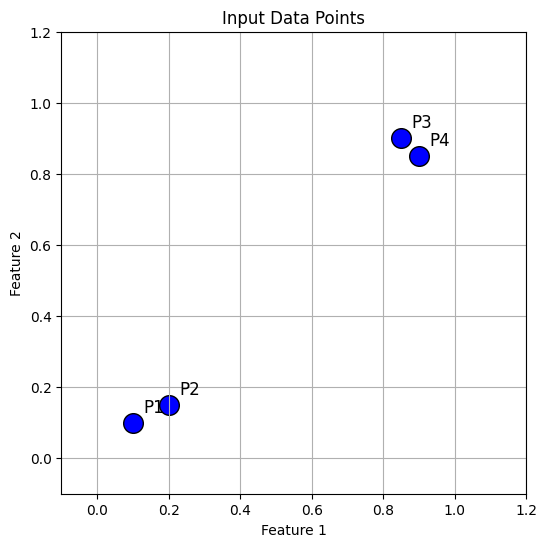

In [2]:
# Simple 2D data: 4 points to be clustered into 2 clusters
# Cluster 1: points near (0, 0)
# Cluster 2: points near (1, 1)

X = torch.tensor([
    [0.1, 0.1],   # Cluster 1
    [0.2, 0.15],  # Cluster 1
    [0.85, 0.9],  # Cluster 2
    [0.9, 0.85],  # Cluster 2
], dtype=torch.float32)

print("Input Data (4 points, 2 features):")
print(X)

# Visualize the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), s=200, c='blue', edgecolors='black')
for i, point in enumerate(X):
    plt.annotate(f'P{i+1}', (point[0]+0.03, point[1]+0.03), fontsize=12)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Input Data Points')
plt.xlim(-0.1, 1.2)
plt.ylim(-0.1, 1.2)
plt.grid(True)
plt.show()

In [3]:
# SOM Parameters
grid_rows = 2      # Number of rows in SOM grid
grid_cols = 1      # Number of columns in SOM grid
input_dim = 2      # Dimension of input data
n_neurons = grid_rows * grid_cols

# Initialize weight vectors randomly between 0 and 1
# Shape: (n_neurons, input_dim)
weights = torch.rand(n_neurons, input_dim)

print(f"SOM Grid: {grid_rows} x {grid_cols} = {n_neurons} neurons")
print(f"Each neuron has {input_dim} weights")
print("\nInitial Weights:")
for i in range(n_neurons):
    print(f"Neuron {i}: {weights[i].tolist()}")

SOM Grid: 2 x 1 = 2 neurons
Each neuron has 2 weights

Initial Weights:
Neuron 0: [0.8822692632675171, 0.9150039553642273]
Neuron 1: [0.38286375999450684, 0.9593056440353394]


In [4]:
def get_neuron_positions(rows, cols):
    """
    Get the (row, col) position of each neuron in the grid.
    """
    positions = []
    for i in range(rows):
        for j in range(cols):
            positions.append([i, j])
    return torch.tensor(positions, dtype=torch.float32)

neuron_positions = get_neuron_positions(grid_rows, grid_cols)
print("Neuron positions in grid:")
for i, pos in enumerate(neuron_positions):
    print(f"Neuron {i}: position ({int(pos[0])}, {int(pos[1])})")

Neuron positions in grid:
Neuron 0: position (0, 0)
Neuron 1: position (1, 0)


In [5]:
def find_bmu(input_vector, weights):
    """
    Find the Best Matching Unit (BMU) for a given input vector.
    
    Args:
        input_vector: Shape (input_dim,)
        weights: Shape (n_neurons, input_dim)
    
    Returns:
        bmu_idx: Index of the BMU
        bmu_dist: Distance to the BMU
    """
    # Calculate Euclidean distance from input to all neurons
    distances = torch.sqrt(torch.sum((weights - input_vector) ** 2, dim=1))
    
    # Find the neuron with minimum distance
    bmu_idx = torch.argmin(distances)
    bmu_dist = distances[bmu_idx]
    
    return bmu_idx.item(), bmu_dist.item()

# Test with first input
test_input = X[0]
bmu_idx, bmu_dist = find_bmu(test_input, weights)
print(f"Input: {test_input.tolist()}")
print(f"BMU index: {bmu_idx}")
print(f"BMU weights: {weights[bmu_idx].tolist()}")
print(f"Distance to BMU: {bmu_dist:.4f}")

Input: [0.10000000149011612, 0.10000000149011612]
BMU index: 1
BMU weights: [0.38286375999450684, 0.9593056440353394]
Distance to BMU: 0.9047


In [6]:
def gaussian_neighborhood(bmu_pos, all_positions, sigma):
    """
    Calculate Gaussian neighborhood influence for all neurons.
    
    Args:
        bmu_pos: Position of BMU in grid (row, col)
        all_positions: Positions of all neurons
        sigma: Current neighborhood radius
    
    Returns:
        influence: Influence values for each neuron
    """
    # Calculate grid distance from BMU to all neurons
    distances = torch.sqrt(torch.sum((all_positions - bmu_pos) ** 2, dim=1))
    
    # Gaussian influence
    influence = torch.exp(-(distances ** 2) / (2 * sigma ** 2))
    
    return influence

# Test neighborhood function
test_sigma = 1.0
bmu_pos = neuron_positions[0]
influences = gaussian_neighborhood(bmu_pos, neuron_positions, test_sigma)

print(f"BMU position: {bmu_pos.tolist()}")
print(f"Sigma: {test_sigma}")
print("\nNeighborhood influences:")
for i, inf in enumerate(influences):
    print(f"Neuron {i}: {inf.item():.4f}")

BMU position: [0.0, 0.0]
Sigma: 1.0

Neighborhood influences:
Neuron 0: 1.0000
Neuron 1: 0.6065


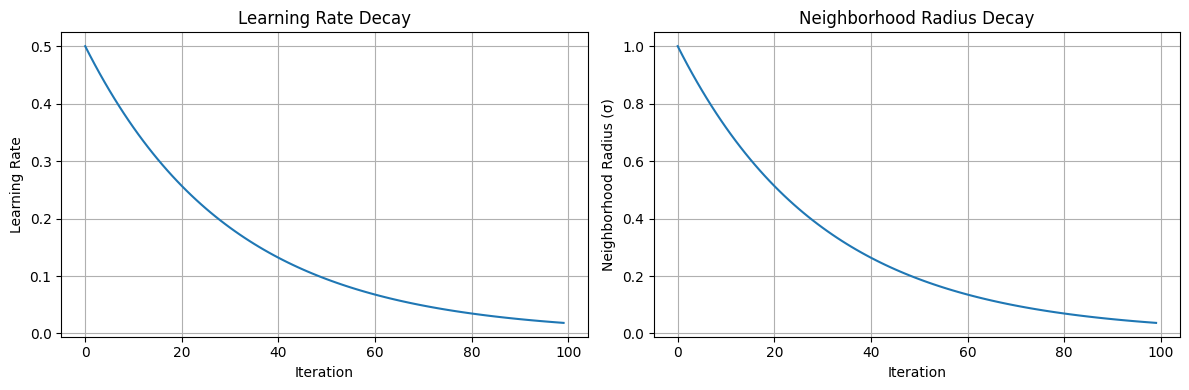

In [7]:
def decay_function(initial_value, current_iteration, time_constant):
    """
    Exponential decay function for learning rate and neighborhood radius.
    """
    return initial_value * np.exp(-current_iteration / time_constant)

# Visualize decay
iterations = np.arange(100)
initial_lr = 0.5
initial_sigma = 1.0
time_constant = 30

lr_decay = [decay_function(initial_lr, t, time_constant) for t in iterations]
sigma_decay = [decay_function(initial_sigma, t, time_constant) for t in iterations]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(iterations, lr_decay)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Learning Rate')
axes[0].set_title('Learning Rate Decay')
axes[0].grid(True)

axes[1].plot(iterations, sigma_decay)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Neighborhood Radius (σ)')
axes[1].set_title('Neighborhood Radius Decay')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [8]:
def update_weights(input_vector, weights, bmu_idx, positions, learning_rate, sigma):
    """
    Update all weights based on the current input and BMU.
    
    Args:
        input_vector: Current input sample
        weights: Current weight matrix
        bmu_idx: Index of the BMU
        positions: Grid positions of all neurons
        learning_rate: Current learning rate
        sigma: Current neighborhood radius
    
    Returns:
        Updated weights
    """
    bmu_pos = positions[bmu_idx]
    
    # Calculate neighborhood influence for all neurons
    influence = gaussian_neighborhood(bmu_pos, positions, sigma)
    
    # Update each neuron's weights
    for i in range(len(weights)):
        # Weight update: W_new = W_old + lr * h * (X - W_old)
        weights[i] = weights[i] + learning_rate * influence[i] * (input_vector - weights[i])
    
    return weights

print("Weight update function defined!")

Weight update function defined!


In [9]:
# Hyperparameters
n_epochs = 100
initial_learning_rate = 0.5
initial_sigma = 1.0
time_constant = n_epochs / 2

# Re-initialize weights
torch.manual_seed(42)
weights = torch.rand(n_neurons, input_dim)

print("Initial Weights:")
for i in range(n_neurons):
    print(f"Neuron {i}: {weights[i].tolist()}")

# Store weight history for visualization
weight_history = [weights.clone()]

# Training loop
for epoch in range(n_epochs):
    # Calculate current learning rate and sigma
    current_lr = decay_function(initial_learning_rate, epoch, time_constant)
    current_sigma = decay_function(initial_sigma, epoch, time_constant)
    
    # Ensure sigma doesn't get too small
    current_sigma = max(current_sigma, 0.01)
    
    # Iterate through all training samples
    for i in range(len(X)):
        # Get current input
        input_vector = X[i]
        
        # Find BMU
        bmu_idx, _ = find_bmu(input_vector, weights)
        
        # Update weights
        weights = update_weights(input_vector, weights, bmu_idx, 
                                neuron_positions, current_lr, current_sigma)
    
    # Store weights periodically
    if epoch % 10 == 0:
        weight_history.append(weights.clone())
        
    # Print progress
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | LR: {current_lr:.4f} | Sigma: {current_sigma:.4f}")

print("\nFinal Weights:")
for i in range(n_neurons):
    print(f"Neuron {i}: {weights[i].tolist()}")

Initial Weights:
Neuron 0: [0.8822692632675171, 0.9150039553642273]
Neuron 1: [0.38286375999450684, 0.9593056440353394]
Epoch   0 | LR: 0.5000 | Sigma: 1.0000
Epoch  20 | LR: 0.3352 | Sigma: 0.6703
Epoch  40 | LR: 0.2247 | Sigma: 0.4493
Epoch  60 | LR: 0.1506 | Sigma: 0.3012
Epoch  80 | LR: 0.1009 | Sigma: 0.2019

Final Weights:
Neuron 0: [0.876011848449707, 0.8739820718765259]
Neuron 1: [0.15203362703323364, 0.1260189265012741]


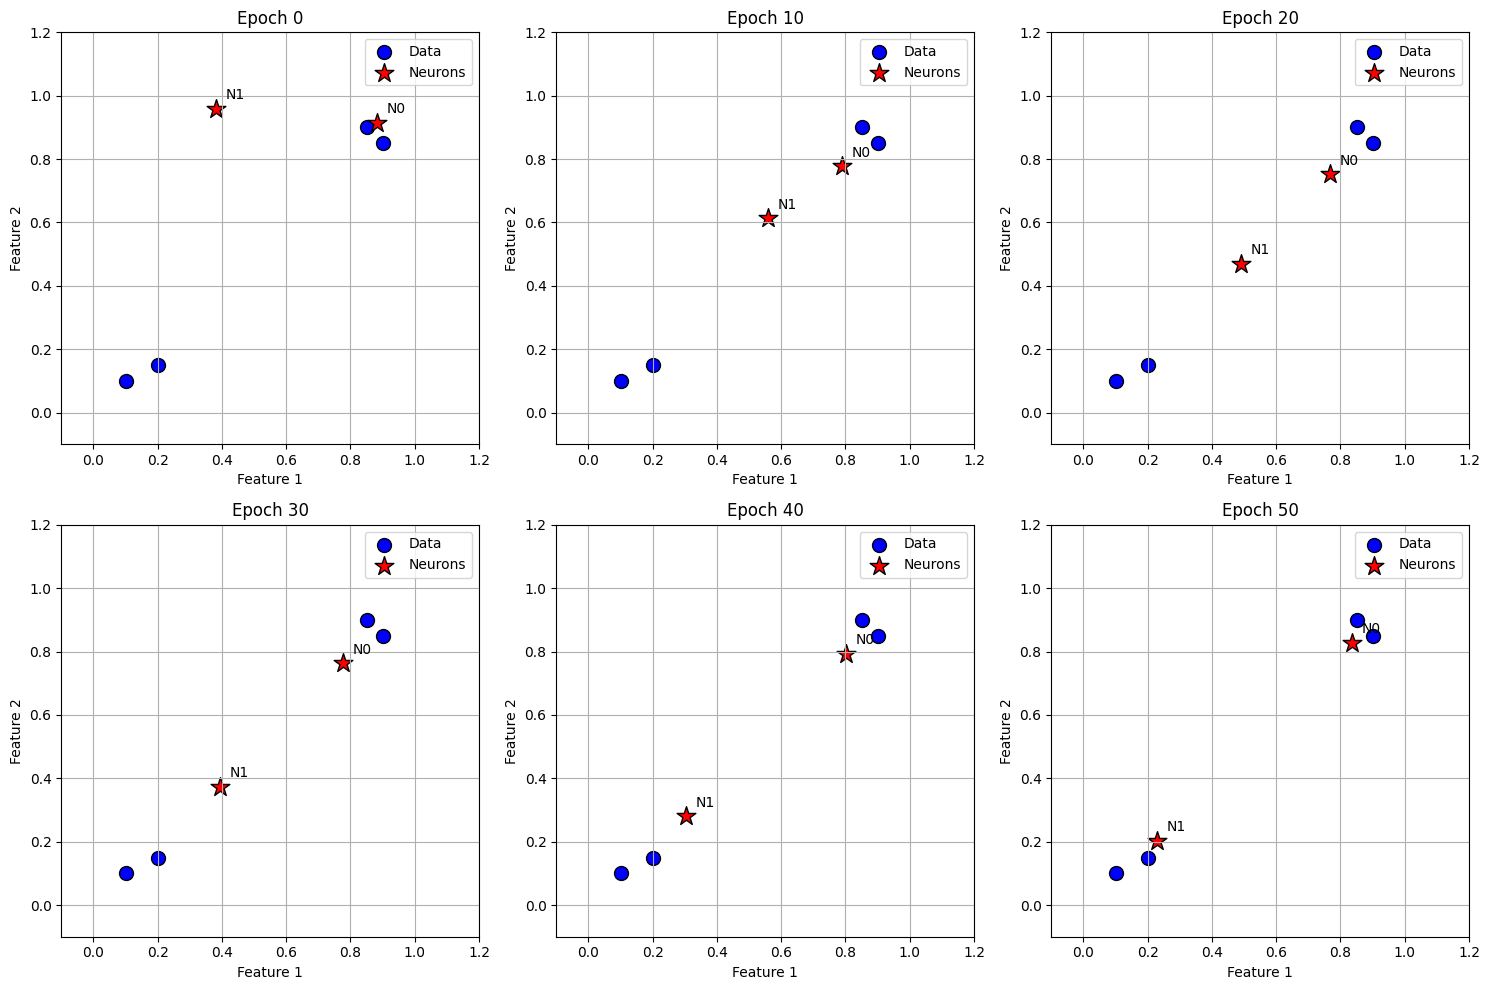

In [10]:
# Plot how weights evolved during training
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (ax, w) in enumerate(zip(axes, weight_history[:6])):
    # Plot data points
    ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), 
               s=100, c='blue', label='Data', edgecolors='black')
    
    # Plot neuron weights
    ax.scatter(w[:, 0].numpy(), w[:, 1].numpy(), 
               s=200, c='red', marker='*', label='Neurons', edgecolors='black')
    
    # Add labels to neurons
    for i, weight in enumerate(w):
        ax.annotate(f'N{i}', (weight[0]+0.03, weight[1]+0.03), fontsize=10)
    
    ax.set_xlim(-0.1, 1.2)
    ax.set_ylim(-0.1, 1.2)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'Epoch {idx * 10}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Find which neuron each data point belongs to
print("Cluster Assignments:")
print("=" * 50)

cluster_assignments = []
for i, x in enumerate(X):
    bmu_idx, bmu_dist = find_bmu(x, weights)
    cluster_assignments.append(bmu_idx)
    print(f"Point {i+1} {x.tolist()} → Neuron {bmu_idx} (distance: {bmu_dist:.4f})")

print("\nCluster Summary:")
for neuron_idx in range(n_neurons):
    points_in_cluster = [i+1 for i, c in enumerate(cluster_assignments) if c == neuron_idx]
    print(f"Neuron {neuron_idx}: Points {points_in_cluster}")

Cluster Assignments:
Point 1 [0.10000000149011612, 0.10000000149011612] → Neuron 1 (distance: 0.0582)
Point 2 [0.20000000298023224, 0.15000000596046448] → Neuron 1 (distance: 0.0536)
Point 3 [0.8500000238418579, 0.8999999761581421] → Neuron 0 (distance: 0.0368)
Point 4 [0.8999999761581421, 0.8500000238418579] → Neuron 0 (distance: 0.0339)

Cluster Summary:
Neuron 0: Points [3, 4]
Neuron 1: Points [1, 2]


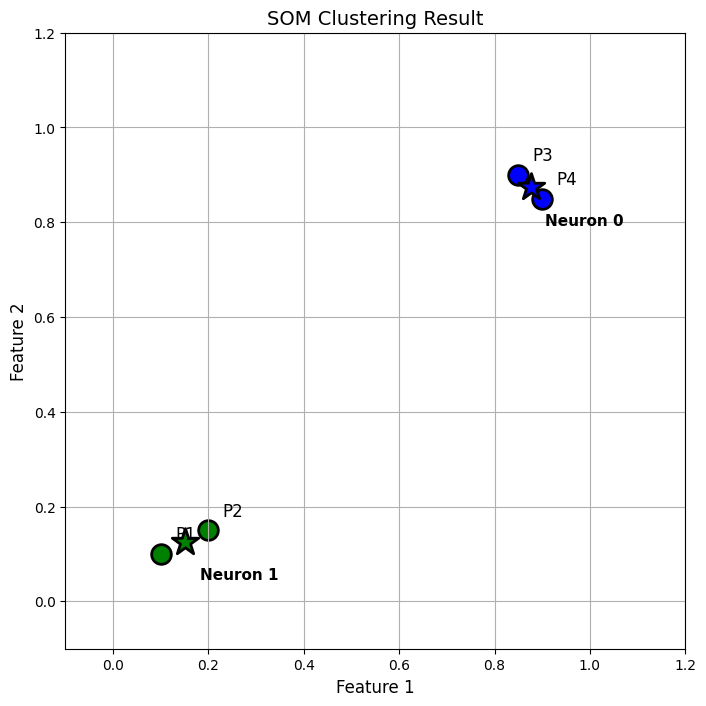


✓ SOM has successfully clustered the 4 points into 2 clusters!


In [12]:
# Final visualization with clusters
plt.figure(figsize=(8, 8))

# Define colors for each cluster
colors = ['blue', 'green', 'orange', 'purple']

# Plot data points colored by cluster
for i, x in enumerate(X):
    cluster = cluster_assignments[i]
    plt.scatter(x[0].numpy(), x[1].numpy(), 
               s=200, c=colors[cluster], edgecolors='black', linewidth=2)
    plt.annotate(f'P{i+1}', (x[0]+0.03, x[1]+0.03), fontsize=12)

# Plot final neuron positions
for i, w in enumerate(weights):
    plt.scatter(w[0].numpy(), w[1].numpy(), 
               s=400, c=colors[i], marker='*', edgecolors='black', linewidth=2)
    plt.annotate(f'Neuron {i}', (w[0]+0.03, w[1]-0.08), fontsize=11, fontweight='bold')

plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('SOM Clustering Result', fontsize=14)
plt.xlim(-0.1, 1.2)
plt.ylim(-0.1, 1.2)
plt.grid(True)
plt.show()

print("\n✓ SOM has successfully clustered the 4 points into 2 clusters!")